<h1><center>CS 455/595a: Decision Trees</center></h1>
<center>Richard S. Stansbury</center>

This notebook applies the decision tree (DT) classification and regression concepts concepts covered in [1] with the [Titanic](https://www.kaggle.com/c/titanic/) and [Boston Housing](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) data sets for DT-based classification and regression, respectively.

Note: you must install the graphviz package for Python.  Please do this install using pip or conda. i.e. "pip install graphviz" or "conda install graphviz"

Reference:

[1] Aurelen Geron. *Hands on Machine Learning with Scikit-Learn & TensorFlow* O'Reilley Media Inc, 2017.

[2] Aurelen Geron. "ageron/handson-ml: A series of Jupyter notebooks that walk you through the fundamentals of Machine Learning and Deep Learning in python using Scikit-Learn and TensorFlow." Github.com, online at: https://github.com/ageron/handson-ml [last accessed 2019-03-01]

**Table of Contents**
1. [Titanic Survivor Classifier w/ Decision Trees](#Titanic-Survivor-Classifier)
 
2. [Boston Housing Cost Estimator w/ Decision Tree](#Boston-Housing-Cost-Estimator)

# Titanic Survivor Classifier

## Set up - Imports of libraries and Data Preparation

In [1]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn import datasets

from matplotlib import pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd
import os

# Read data from input files into Pandas data frames
data_path = os.path.join("datasets","titanic")
train_filename = "train.csv"
test_filename = "test.csv"

def read_csv(data_path, filename):
    joined_path = os.path.join(data_path, filename)
    return pd.read_csv(joined_path)

# Read CSV file into Pandas Dataframes
train_df = read_csv(data_path, train_filename)

# Defining Data Pre-Processing Pipelines
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attributes):
        self.attributes = attributes
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attributes]

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.most_frequent = pd.Series([X[c].value_counts().index[0] for c in X], 
                                       index = X.columns)
        return self
    
    def transform(self, X):
        return X.fillna(self.most_frequent)

    
numeric_pipe = Pipeline([
        ("Select", DataFrameSelector(["Age", "Fare", "SibSp", "Parch"])), # Selects Fields from dataframe
        ("Imputer", SimpleImputer(strategy="median")),   # Fills in NaN w/ median value for its column
    ])

#Handle categorical string for sex by encoding as female true, 1 or false,0
train_df['Female'] = train_df["Sex"].apply(lambda x: 1 if x == 'female' else 0)

categories_pipe = Pipeline([
        ("Select", DataFrameSelector(["Pclass", "Female"])), # Selects Fields from dataframe
        ("MostFreqImp", MostFrequentImputer()), # Fill in NaN with most frequent
    ])

preprocessing_pipe = FeatureUnion(transformer_list = [
        ("numeric pipeline", numeric_pipe), 
        ("categories pipeline", categories_pipe)
     ]) 

# Process Input Data Using Pipleines
train_X_data = preprocessing_pipe.fit_transform(train_df)

train_y_data = train_df["Survived"]

## KNN Classifier Performance vs. Metrics (for comparison)

In [2]:
# KNN Classifier 10-fold Validation
k=10
clf = KNeighborsClassifier(n_neighbors=k)

y_pred = cross_val_predict(clf, train_X_data, train_y_data, cv=5)

print("Confusion Matrix:")
print(confusion_matrix(train_y_data, y_pred))
print("Accuracy Score = " + str(accuracy_score(train_y_data, y_pred)))
print("Pecision Score = " + str(precision_score(train_y_data, y_pred)))
print("Recall Score = " + str(recall_score(train_y_data,y_pred)))
print("F1 Score = " + str(f1_score(train_y_data,y_pred)))                            
                               

Confusion Matrix:
[[451  98]
 [176 166]]
Accuracy Score = 0.6924803591470258
Pecision Score = 0.6287878787878788
Recall Score = 0.4853801169590643
F1 Score = 0.5478547854785478


## Decision Tree Performance vs. Metrics

In [3]:
from sklearn.tree import DecisionTreeClassifier


clf2 = DecisionTreeClassifier(max_depth=10)

y_pred = cross_val_predict(clf2, train_X_data, train_y_data, cv=5)

print("Confusion Matrix:")
print(confusion_matrix(train_y_data, y_pred))
print("Accuracy Score = " + str(accuracy_score(train_y_data, y_pred)))
print("Pecision Score = " + str(precision_score(train_y_data, y_pred)))
print("Recall Score = " + str(recall_score(train_y_data,y_pred)))
print("F1 Score = " + str(f1_score(train_y_data,y_pred))) 

Confusion Matrix:
[[485  64]
 [106 236]]
Accuracy Score = 0.8092031425364759
Pecision Score = 0.7866666666666666
Recall Score = 0.6900584795321637
F1 Score = 0.735202492211838


## Example: Visulaization of DT with Maximum Depth Constrained

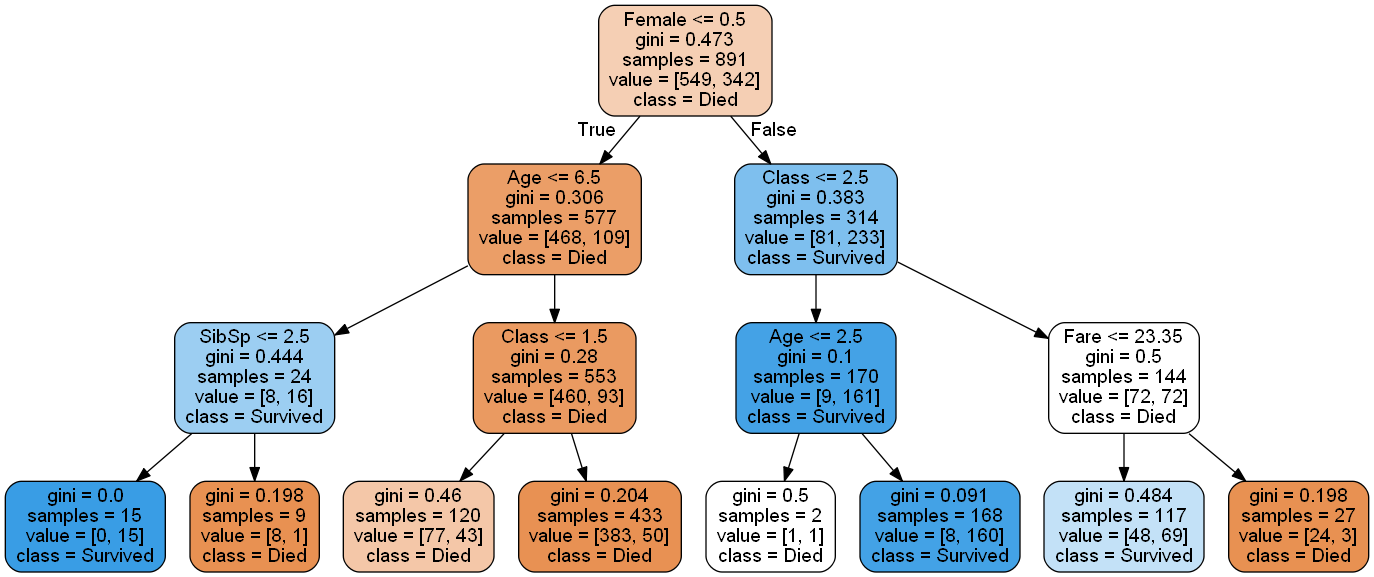

In [4]:
#!conda install graphviz

from sklearn.tree import export_graphviz
from IPython.display import Image as PImage

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(train_X_data, train_y_data)

feature_names = ["Age", "Fare", "SibSp", "Parch", "Class", "Female"]
target_names = ["Died","Survived"]

export_graphviz(
        clf,
        out_file="titanic1.dot",
        feature_names=feature_names,
        class_names=target_names,
        rounded=True,
        filled=True
    )
!dot -Tpng titanic1.dot -o titanic1.png

PImage('titanic1.png')


## Example: Visualization of DT w/ minimum leaf samples constrained.

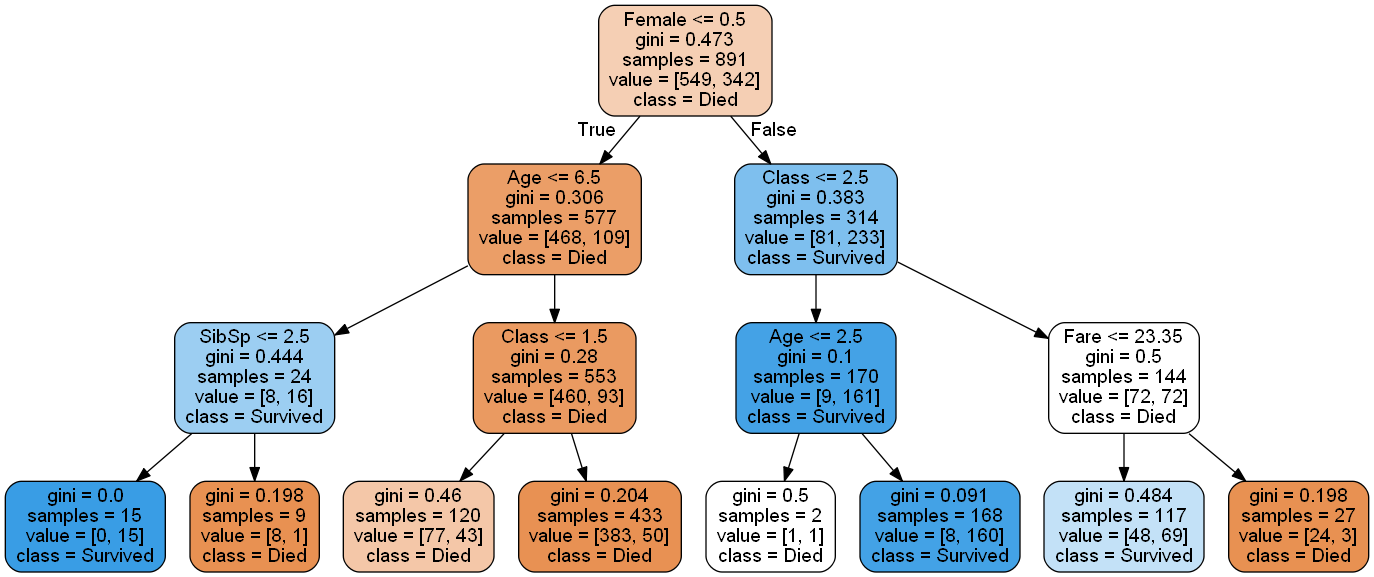

In [5]:
from sklearn.tree import export_graphviz
from IPython.display import Image as PImage

clf = DecisionTreeClassifier(min_samples_leaf=50)
clf.fit(train_X_data, train_y_data)

feature_names = ["Age", "Fare", "SibSp", "Parch", "Class", "Female"]
target_names = ["Died","Survived"]

export_graphviz(
        clf,
        out_file="titanic2.dot",
        feature_names=feature_names,
        class_names=target_names,
        rounded=True,
        filled=True
    )
!dot -Tpng titanic2.dot -o titanic2.png

PImage('titanic1.png')


# Boston Housing Cost Estimator

## Setup

In [6]:
# Load Data Set
boston_housing_data = datasets.load_boston()

train_X, test_X, train_y, test_y = train_test_split(boston_housing_data.data,
                                                   boston_housing_data.target,
                                                   test_size=0.33)


def plot_learning_curves(model, X, y):
    """
    Plots performance on the training set and testing (validation) set.
    X-axis - number of training samples used
    Y-axis - RMSE
    """
    
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.20)
    
    training_errors, validation_errors = [], []
    
    for m in range(1, len(train_X)):
        
        model.fit(train_X[:m], train_y[:m])
        
        train_pred = model.predict(train_X)
        test_pred = model.predict(test_X)
        
        training_errors.append(np.sqrt(mean_squared_error(train_y, train_pred)))
        validation_errors.append(np.sqrt(mean_squared_error(test_y, test_pred)))
        
    plt.plot(training_errors, "r-+", label="train")
    plt.plot(validation_errors, "b-", label="test")
    plt.legend()
    plt.axis([0, 80, 0, 3])

## Linear Regression on Boston Data Set (for comparison)

Theta:
31.434931823001907 [-1.42044889e-01  3.76697767e-02 -9.77293080e-02  1.33759363e+00
 -1.13517774e+01  4.05949394e+00 -2.74994830e-02 -1.55760627e+00
  3.01381929e-01 -1.21473529e-02 -8.76375897e-01  1.04677364e-02
 -3.88152380e-01]
MAE = 3.9017195371137836


[0, 300, 0, 10]

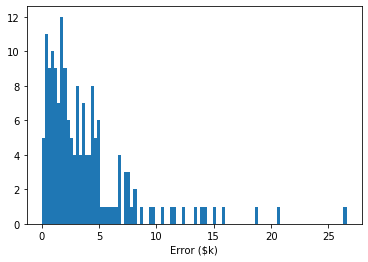

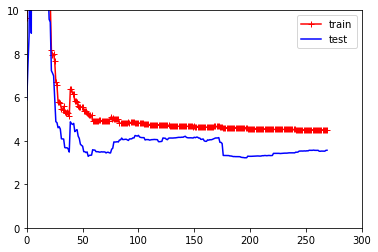

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_X,train_y)
pred_y = lin_reg.predict(test_X)

# Outputs the intercept and coefficient of the model (theta_0 and theta_1 respectively)
print("Theta:")
print(lin_reg.intercept_, lin_reg.coef_)

plt.figure("a")
plt.hist(abs(test_y - pred_y),bins=100)
plt.xlabel("Error ($k)")

print("MAE = " + str(mean_absolute_error(test_y, pred_y)))

plt.figure("b")
plot_learning_curves(lin_reg, train_X, train_y)
plt.axis([0,300,0,10])

## Decision Tree Regressor Example

MAE = 2.9533759446247627


[0, 300, 0, 10]

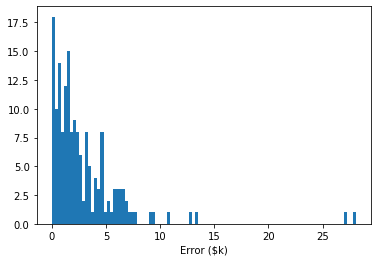

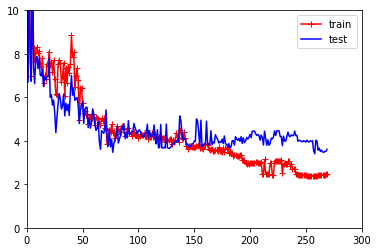

In [8]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=5)
reg.fit(train_X,train_y)
pred_y = reg.predict(test_X)

plt.figure("a")
plt.hist(abs(test_y - pred_y),bins=100)
plt.xlabel("Error ($k)")

print("MAE = " + str(mean_absolute_error(test_y, pred_y)))

plt.figure("b")
plot_learning_curves(reg, train_X, train_y)
plt.axis([0,300,0,10])

## Visualizing Decision Tree for Regression

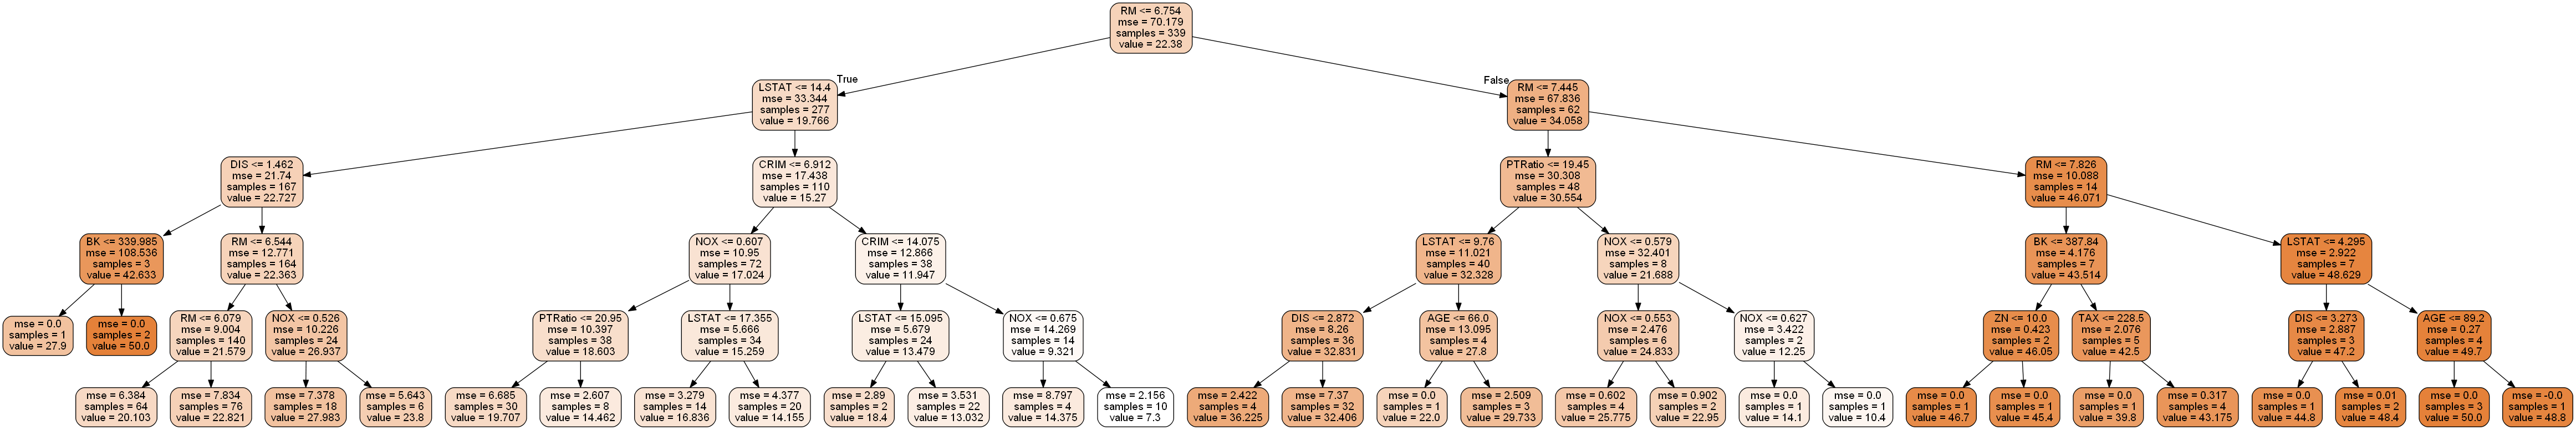

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image as PImage


reg = DecisionTreeRegressor(max_depth=5)
reg.fit(train_X,train_y)

feature_names = ["CRIM", "ZN","INDUS","CHAS", "NOX","RM","AGE",
                           "DIS","RAD","TAX","PTRatio","BK", "LSTAT"]

target_names=["Value"]

export_graphviz(
        reg,
        out_file="boston1.dot",
        feature_names=feature_names,
        class_names=target_names,
        rounded=True,
        filled=True
    )
!dot -Tpng boston1.dot -o boston1.png

PImage('boston1.png')